In [1]:
from ModMNIST import ModMNIST
from MNISTExperiment import *
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
torch.manual_seed(43)

In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
label_filter = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
trainset = ModMNIST(train=True, filt_labels=label_filter)
testset = ModMNIST(train=False, filt_labels=label_filter)

BATCH_SIZE = 1024

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
fc_output_size = testloader.dataset.labels.max().item() + 1
print(f'fully connected layer output size: {fc_output_size}')

fully connected layer output size: 40


In [6]:
def get_after_conv_data(model, dataloader):
    activation = {}

    def getActivation(name):
        # the hook signature
        def hook(model, input, output):
            activation[name] = output.cpu().detach()
        return hook
    
    data = []
    hook = model.conv[2].register_forward_hook(getActivation('conv'))
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            data.append(activation['conv'].flatten())
    hook.remove()
    
    return torch.cat(data)

In [7]:
CONV_OUT_CHANNEL_SIZE = 50

modelWithoutPooling = CNN(conv_out_channels=CONV_OUT_CHANNEL_SIZE, conv_kernel_size=2, fc_out_size=fc_output_size, batch_size=BATCH_SIZE).to(device)
exp1 = MNISTExperiment(filtered_labels=label_filter, trainloader=trainloader, testloader=testloader, model=modelWithoutPooling, fc_out_size=fc_output_size, print_grad=True)

100%|██████████| 5/5 [01:03<00:00, 12.79s/it]


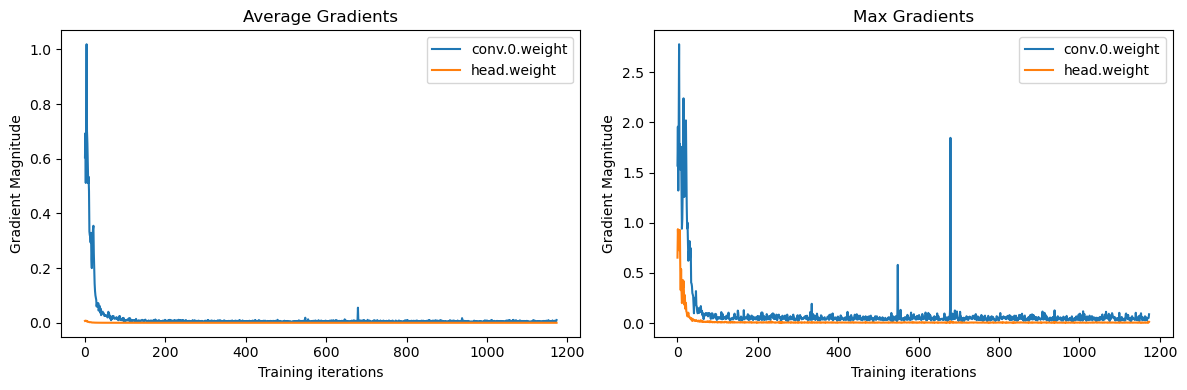

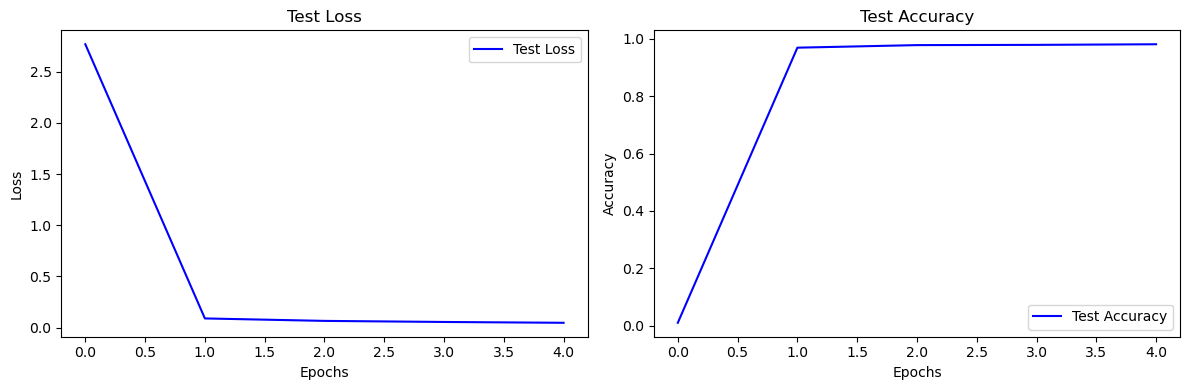

In [8]:
exp1.run(epochs=5)

accuracy on classes: 0.98095, accuracy on positions: 1.0


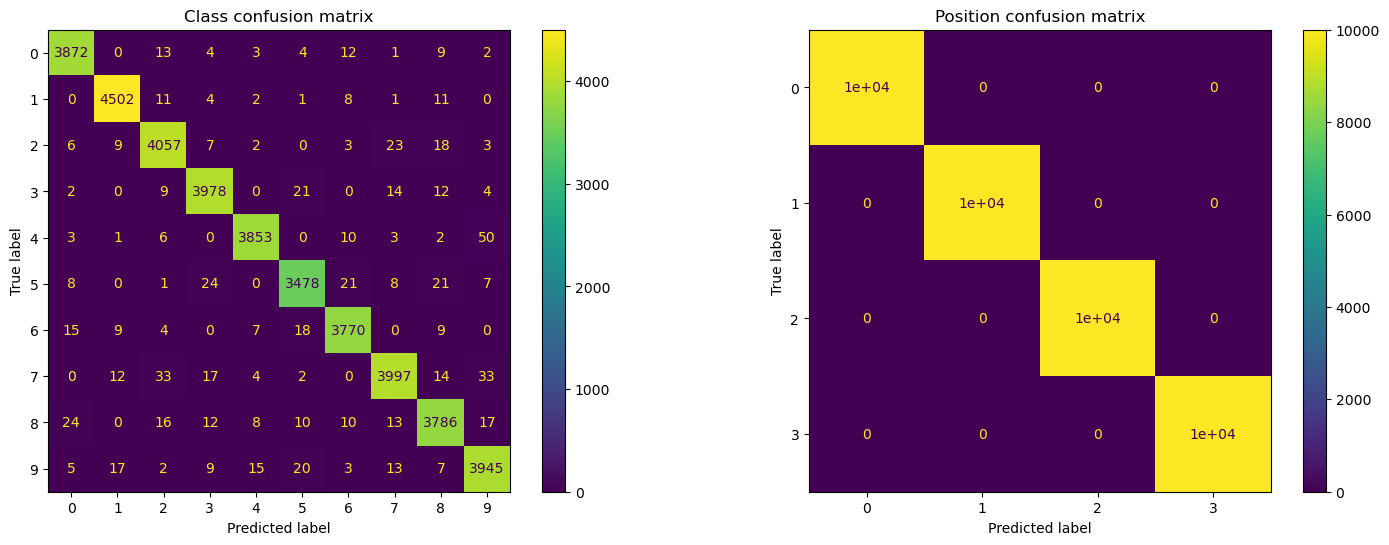

In [9]:
exp1.display_confusion_matrices()

In [10]:
modelWithPooling = CNNWithPoolingAug(conv_out_channels=CONV_OUT_CHANNEL_SIZE, conv_kernel_size=2, pool_size=None, pooling=torch.nn.AvgPool2d, fc_out_size=fc_output_size, batch_size=BATCH_SIZE).to(device)
modelWithPooling.conv[0] = modelWithoutPooling.conv[0]
modelWithPooling.conv[1] = modelWithoutPooling.conv[1]
modelWithPooling.conv.apply(lambda m: set_requires_grad(m, False))

exp2 = MNISTExperiment(filtered_labels=label_filter, trainloader=trainloader, testloader=testloader, model=modelWithPooling, fc_out_size=fc_output_size, print_grad=True)

100%|██████████| 100/100 [17:16<00:00, 10.37s/it]


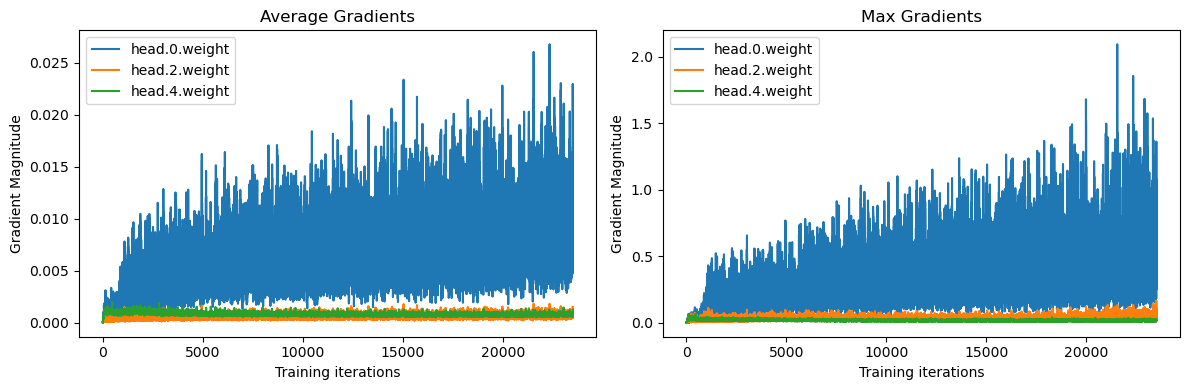

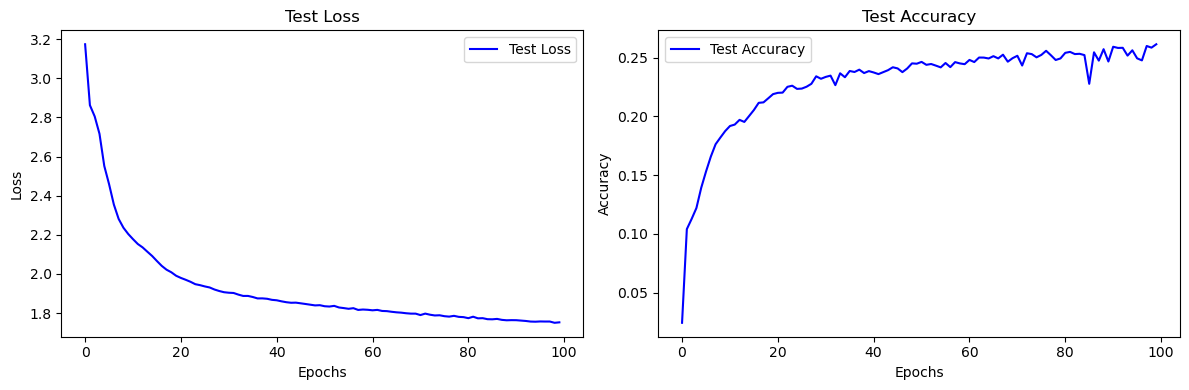

In [11]:
exp2.run(epochs=100)

accuracy on classes: 0.861425, accuracy on positions: 0.29845


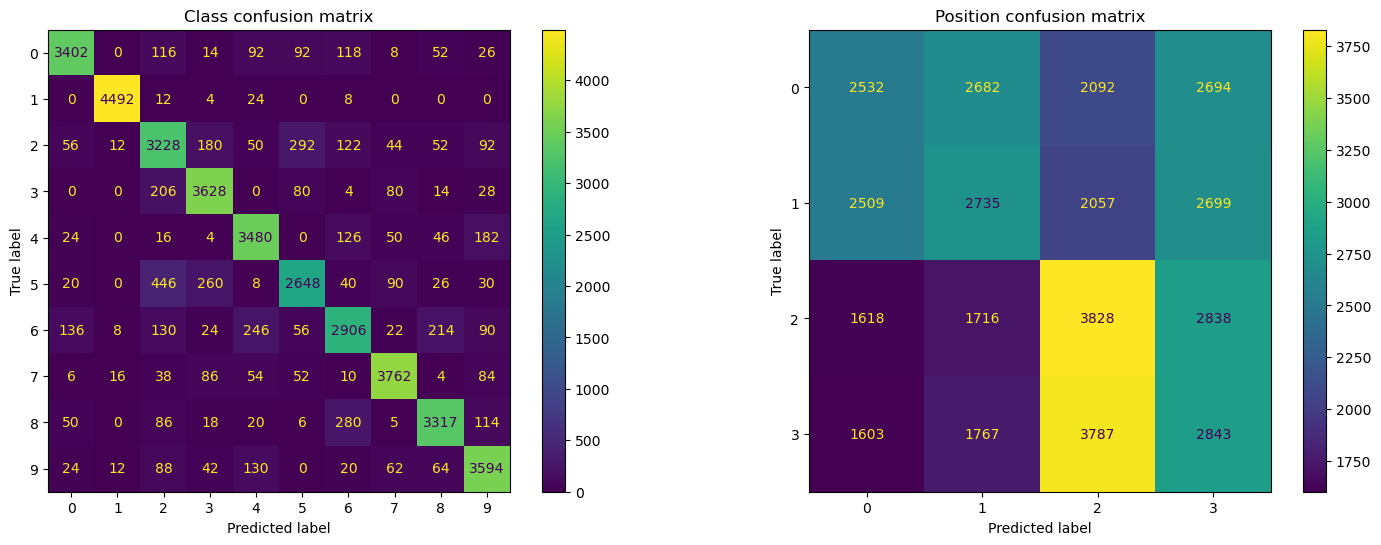

In [12]:
exp2.display_confusion_matrices()

In [13]:
betterModelWithoutPooling = BetterCNN(conv_out_channels=CONV_OUT_CHANNEL_SIZE, conv_kernel_size=2, fc_out_size=fc_output_size, batch_size=BATCH_SIZE).to(device)
exp4 = MNISTExperiment(filtered_labels=label_filter, trainloader=trainloader, testloader=testloader, model=betterModelWithoutPooling, fc_out_size=fc_output_size, print_grad=True)

100%|██████████| 5/5 [02:45<00:00, 33.16s/it]


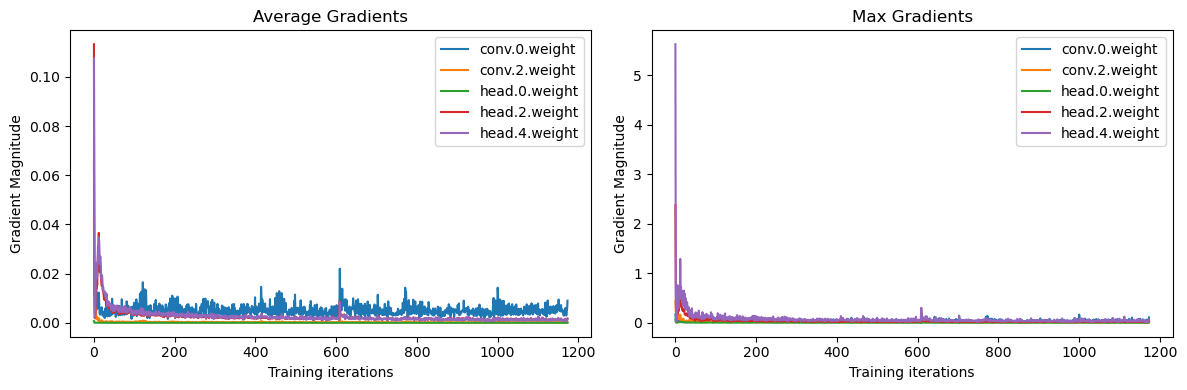

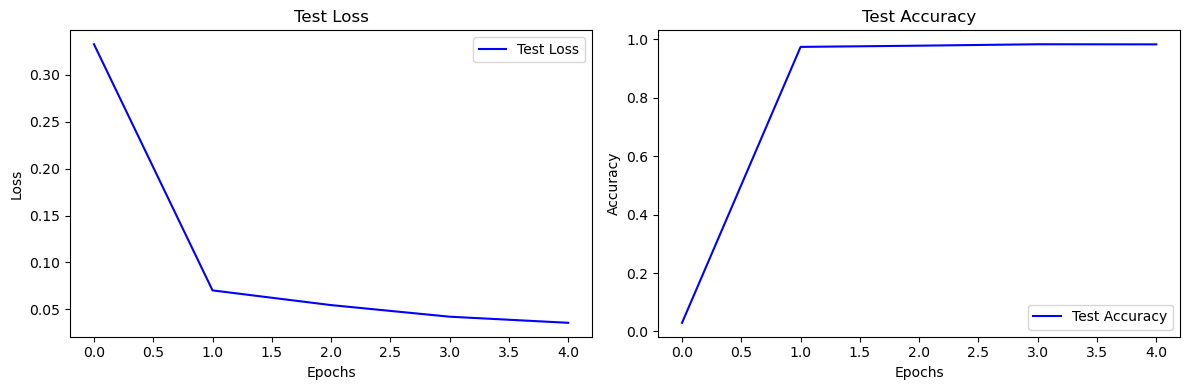

In [14]:
exp4.run()

accuracy on classes: 0.983475, accuracy on positions: 0.999975


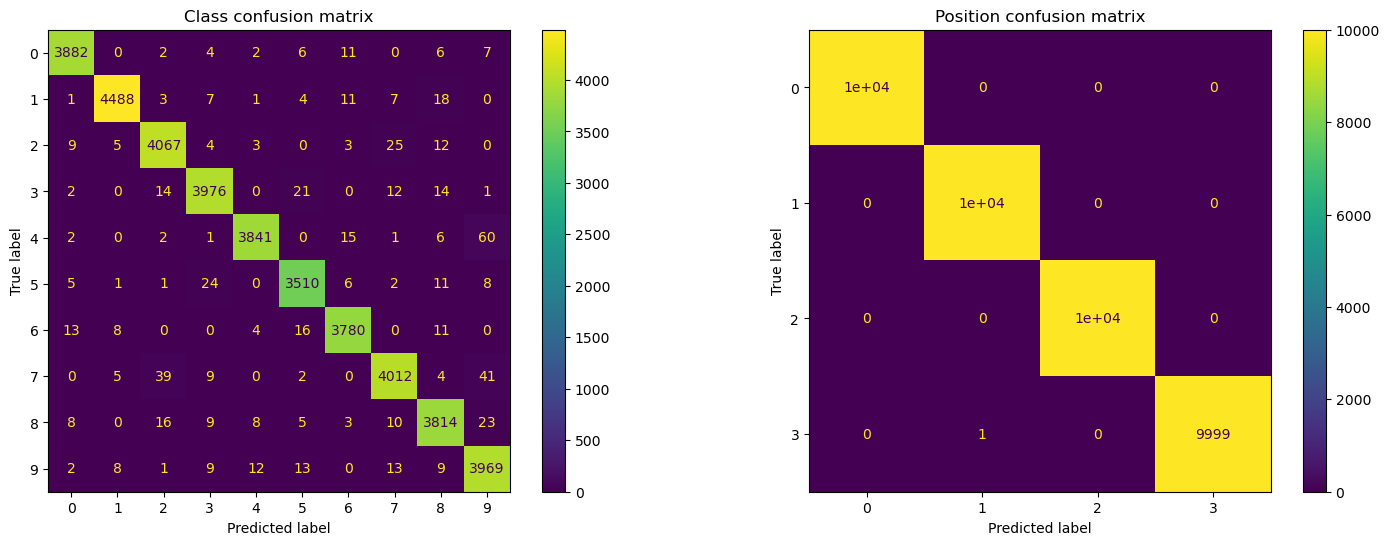

In [15]:
exp4.display_confusion_matrices()

In [16]:
betterModelWithPooling = BetterCNNWithPooling(conv_out_channels=CONV_OUT_CHANNEL_SIZE, conv_kernel_size=2, pool_size=None, pooling=torch.nn.AvgPool2d, fc_out_size=fc_output_size, batch_size=BATCH_SIZE).to(device)
betterModelWithPooling.conv[0] = betterModelWithoutPooling.conv[0]
betterModelWithPooling.conv[1] = betterModelWithoutPooling.conv[1]
betterModelWithPooling.conv[2] = betterModelWithoutPooling.conv[2]
betterModelWithPooling.conv[3] = betterModelWithoutPooling.conv[3]
betterModelWithPooling.conv.apply(lambda m: set_requires_grad(m, False))

exp5 = MNISTExperiment(filtered_labels=label_filter, trainloader=trainloader, testloader=testloader, model=betterModelWithPooling, fc_out_size=fc_output_size, print_grad=True)

100%|██████████| 100/100 [22:54<00:00, 13.74s/it]


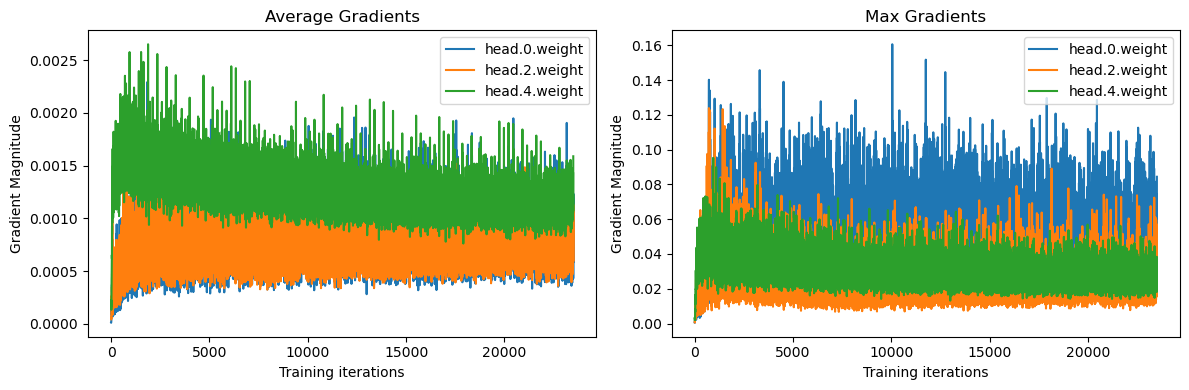

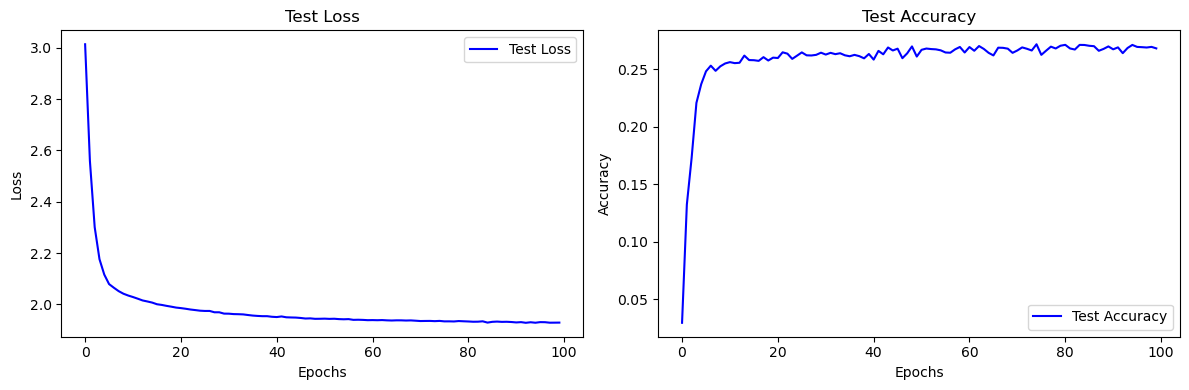

In [17]:
exp5.run(epochs=100)

accuracy on classes: 0.76115, accuracy on positions: 0.33805


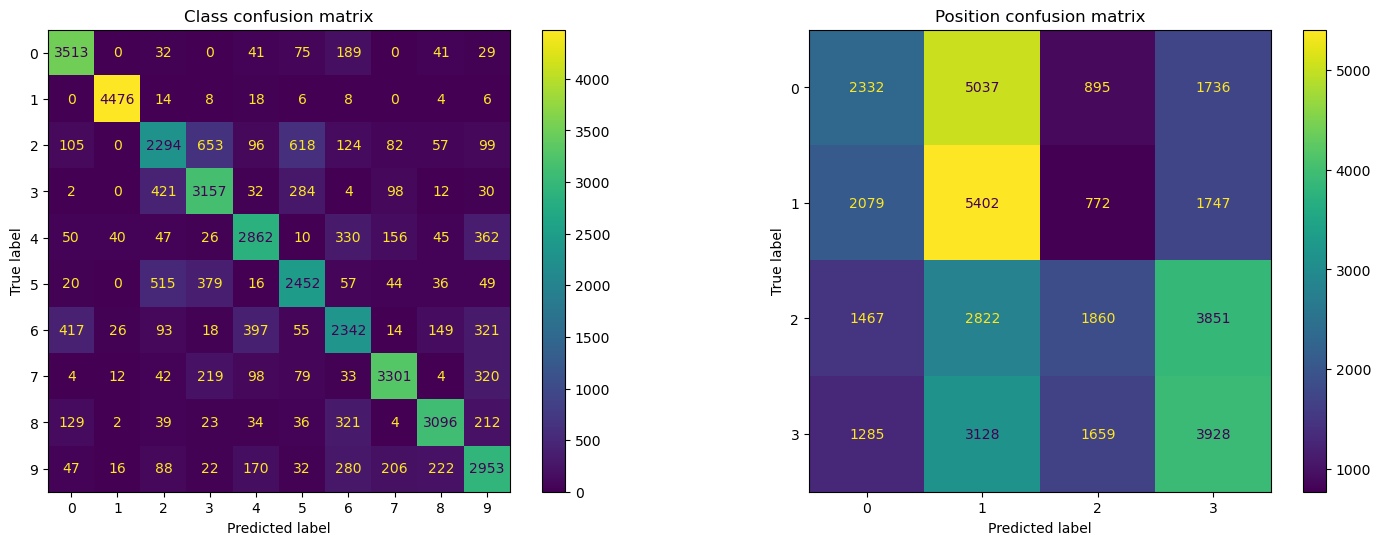

In [18]:
exp5.display_confusion_matrices()